In [1]:
import sys

# make sure you are using `gyrointerp` environment
assert sys.executable.split('/')[5]=='af'

In [2]:
from allesfitter import config, allesclass

datadir = '/ut3/jerome/github/research/project/TIC-89071445/allesfitter/tess_lco/wo_rhostar_prior'
alles = allesclass(datadir, quiet=True)

Filling the Basement

OrderedDict([('user-given:', ''),
             ('companions_phot', ['b']),
             ('companions_rv', []),
             ('inst_phot',
              ['qlp200', 'qlp600', 'lco_g', 'lco_z', 'lco_g2', 'lco_z2']),
             ('inst_rv', []),
             ('multiprocess', True),
             ('multiprocess_cores', '80'),
             ('fast_fit', 'True'),
             ('fast_fit_width', '0.3333333333333333'),
             ('secondary_eclipse', 'False'),
             ('phase_curve', 'False'),
             ('shift_epoch', True),
             ('inst_for_b_epoch',
              ['qlp200', 'qlp600', 'lco_g', 'lco_z', 'lco_g2', 'lco_z2']),
             ('mcmc_nwalkers', '100'),
             ('mcmc_total_steps', '2000'),
             ('mcmc_burn_steps', '1000'),
             ('mcmc_thin_by', '2'),
             ('ns_modus', 'dynamic'),
             ('ns_nlive', '1000'),
             ('ns_bound', 'single'),
             ('ns_sample', 'auto'),
             ('ns_tol', '0.01'

In [3]:
alles.__dict__.keys()

dict_keys(['BASEMENT', 'fulldata', 'data', 'settings', 'labels', 'initial_guess_samples', 'initial_guess_params_median', 'external_priors', 'posterior_samples', 'posterior_params', 'posterior_params_median', 'posterior_params_ll', 'posterior_params_ul', 'posterior_derived_params'])

In [6]:
alles.BASEMENT.__dict__.keys()

dict_keys(['quiet', 'now', 'datadir', 'outdir', 'settings', 'allkeys', 'labels', 'units', 'truths', 'params', 'coupled_with', 'ind_fit', 'fitkeys', 'fitlabels', 'fitunits', 'fittruths', 'theta_0', 'init_err', 'bounds', 'ndim', 'fulldata', 'data', 'external_priors', 'ldcode_to_ldstr'])

In [7]:
alles.fulldata.keys()

dict_keys(['qlp200', 'qlp600', 'lco_g', 'lco_z', 'lco_g2', 'lco_z2'])

In [9]:
alles.fulldata['qlp200'].keys()

dict_keys(['time', 'flux', 'err_scales_flux', 'custom_series', 'b_ind_in', 'b_ind_out', 'all_ind_in', 'all_ind_out'])

In [8]:
alles.data.keys()

dict_keys(['qlp200', 'qlp600', 'lco_g', 'lco_z', 'lco_g2', 'lco_z2', 'inst_phot', 'inst_rv', 'inst_rv2'])

In [10]:
alles.data['qlp200'].keys()

dict_keys(['time', 'flux', 'err_scales_flux', 'custom_series'])

In [16]:
 alles.fulldata[lc_name]['time']

array([2460068.74718206, 2460068.74949694, 2460068.75181182, ...,
       2460096.58758571, 2460096.58990049, 2460096.59221527])

## plotting

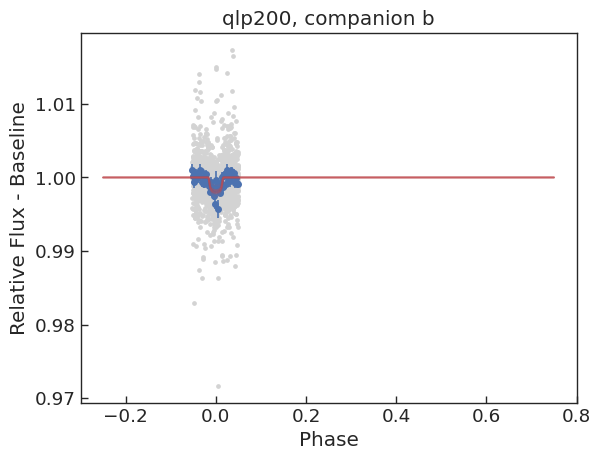

In [51]:
lc_name = 'qlp200'
key = 'flux'
fig, axs = alles.plot(lc_name, 'b', style='phase')

100%|███████████████████████████████████████████| 28/28 [00:06<00:00,  4.39it/s]


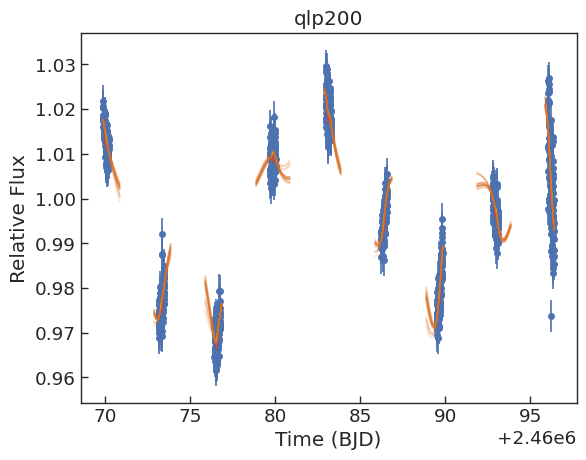

In [53]:
fig, axs = alles.plot(lc_name, 'b', style='full')

## raw data (in-transit)

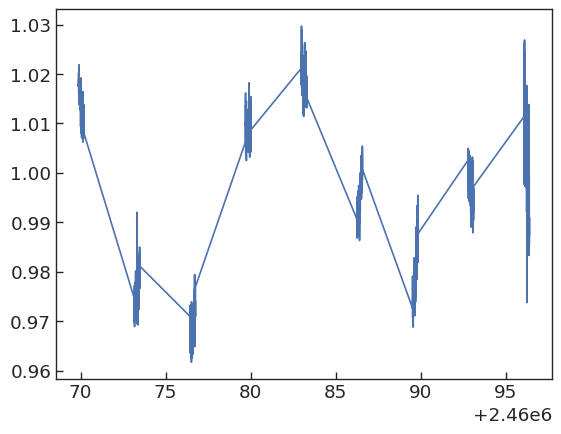

In [17]:
import matplotlib.pyplot as plt

df = alles.fulldata[lc_name]
t = alles.fulldata[lc_name]['time']
f = alles.fulldata[lc_name]['flux']
idx = alles.fulldata[lc_name]['b_ind_in']
plt.plot(t[idx], f[idx])

## baseline model

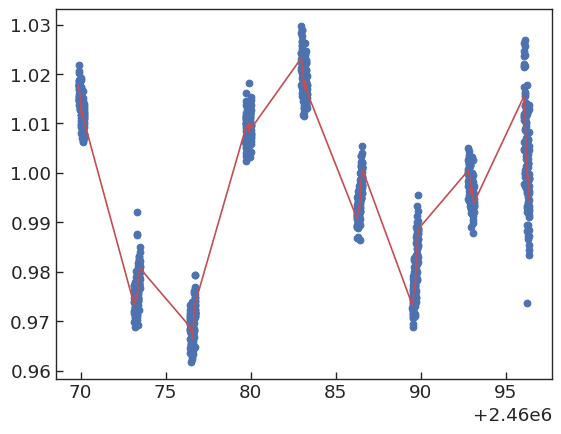

In [30]:
b = alles.get_posterior_median_baseline(lc_name, key, xx=t)
m = alles.get_posterior_median_model(lc_name, key, xx=t)

plt.scatter(t[idx], f[idx])
plt.plot(t[idx], b[idx]+m[idx], 'r')

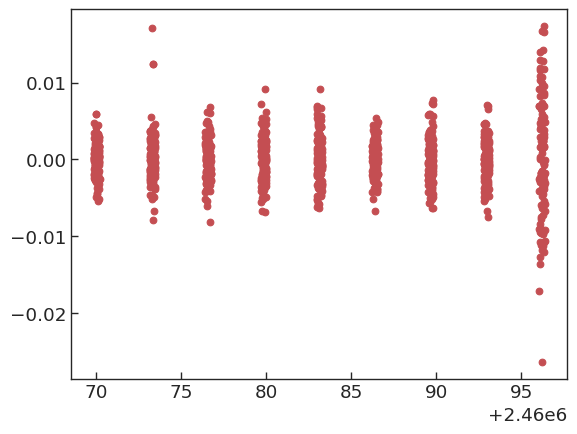

In [40]:
key = 'flux'
# r = alles.get_posterior_median_residuals(lc_name, key)
r = f[idx] - b[idx] -m[idx]

plt.scatter(t[idx], r, color='r')

### results

In [3]:
len(alles.BASEMENT.fitunits)

31

In [4]:
len(alles.BASEMENT.fitlabels)

31

In [5]:
len(alles.BASEMENT.fitkeys)

31

In [ ]:
# config.init(datadir)
# f = gzip.GzipFile(os.path.join(config.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
# results = pickle.load(f)
# f.close()

# posterior_samples = nested_sampling_output.draw_ns_posterior_samples(results)
# posterior_params = nested_sampling_output.draw_ns_posterior_samples(results, as_type='dic') # all weighted posterior_samples
# posterior_params_median, posterior_params_ll, posterior_params_ul = general_output.get_params_from_samples(posterior_samples)    

## posterior into params.csv

In [15]:
from scipy.stats import anderson
import numpy as np

debug = False
text = """#name,value,fit,bounds,label,unit,truth\n"""
# See https://github.com/MNGuenther/allesfitter/blob/master/allesfitter/general_output.py#L935
ll = alles.posterior_params_ll.copy() #1-sigma lower error: 16th per
median = alles.posterior_params_median.copy() #50th percentile
ul = alles.posterior_params_ul.copy() #1-sigma upper error: 84th perc - median
for name,label,unit in zip(alles.BASEMENT.fitkeys,
                           alles.BASEMENT.fitlabels,
                           alles.BASEMENT.fitunits):
    norm_test = anderson(alles.posterior_params[name], dist='norm')
    # critical values: 15%, 10%, 5%, 2.5%, 1%
    # a crit val of 5% corresponds to 95% confidence level
    # if statistic < crit val --> fail to reject normality
    dist = 'normal' if norm_test.statistic < norm_test.critical_values[0] else 'uniform'
    if dist=='normal':
        # or use scipy.normal.fit?
        l_err,mid,u_err = ll[name], median[name], ul[name]
        sig = np.sqrt(l_err**2+u_err**2)
        text += f"{name},{mid:6f},1,normal {mid:6f} {sig:6f},{label},{unit},\n"
        if debug:
            print(f"{mid:.6f} +{u_err:.6f} -{l_err:.6f}")
    elif dist=='uniform':                    
        # or use scipy.uniform.fit?
        l_limit,mid,u_limit = np.nanpercentile(alles.posterior_params[name], q=[1,50,99])
        text += f"{name},{mid:6f},1,uniform {l_limit:6f} {u_limit:6f},{label},{unit},\n"
        if debug:
            print(f"{l_limit:.6f} < {mid:.6f} < {u_limit:.6f}")
    else:
        raise ValueError("distribution is not uniform or normal!") 
print(text)

#name,value,fit,bounds,label,unit,truth
b_rr,0.046443,1,uniform 0.043017 0.050131,$R_b / R_\star$,,
b_rsuma,0.162524,1,uniform 0.151476 0.174353,$(R_\star + R_b) / a_b$,,
b_cosi,0.118893,1,uniform 0.104598 0.133114,$\cos{i_b}$,,
b_epoch,2460076.587075,1,uniform 2460076.583729 2460076.591146,$T_{0;b}$,BJD,
b_period,3.272043,1,uniform 3.272022 3.272067,$P_b$,d,
dil_qlp200,0.061757,1,uniform -0.373683 0.417346,$D_\mathrm{0; qlp200}$,,
dil_qlp600,-0.411130,1,uniform -0.940712 0.152746,$D_\mathrm{0; qlp600}$,,
host_ldc_q1_qlp200,0.547053,1,uniform 0.326566 0.775955,$q_{1; \mathrm{qlp200}}$,,
host_ldc_q2_qlp200,0.155927,1,uniform -0.080262 0.388778,$q_{2; \mathrm{qlp200}}$,,
host_ldc_q1_qlp600,0.539331,1,uniform 0.317286 0.752922,$q_{1; \mathrm{qlp600}}$,,
host_ldc_q2_qlp600,0.131020,1,uniform -0.094511 0.382789,$q_{2; \mathrm{qlp600}}$,,
host_ldc_q1_lco_g2,0.692939,1,uniform 0.459414 0.915404,$q_{1; \mathrm{lco_g2}}$,,
host_ldc_q2_lco_g2,0.562435,1,uniform 0.318815 0.801121,$q_{2; \mathrm{l

## ttv 

In [57]:
from allesfitter import config, allesclass

datadir = '/ut3/jerome/github/research/project/TIC-89071445/allesfitter/ttv/wo_rhostar_prior/'
alles = allesclass(datadir, quiet=True)

Filling the Basement

OrderedDict([('user-given:', ''),
             ('companions_phot', ['b']),
             ('companions_rv', []),
             ('inst_phot',
              ['qlp200', 'qlp600', 'lco_g', 'lco_z', 'lco_g2', 'lco_z2']),
             ('inst_rv', []),
             ('multiprocess', True),
             ('multiprocess_cores', '80'),
             ('fast_fit', 'True'),
             ('fast_fit_width', '0.3333333333333333'),
             ('secondary_eclipse', 'False'),
             ('phase_curve', 'False'),
             ('shift_epoch', True),
             ('inst_for_b_epoch',
              ['qlp200', 'qlp600', 'lco_g', 'lco_z', 'lco_g2', 'lco_z2']),
             ('mcmc_nwalkers', '100'),
             ('mcmc_total_steps', '2000'),
             ('mcmc_burn_steps', '1000'),
             ('mcmc_thin_by', '2'),
             ('ns_modus', 'dynamic'),
             ('ns_nlive', '1000'),
             ('ns_bound', 'single'),
             ('ns_sample', 'auto'),
             ('ns_tol', '0.01'

In [58]:
alles.__dict__.keys()

dict_keys(['BASEMENT', 'fulldata', 'data', 'settings', 'labels', 'initial_guess_samples', 'initial_guess_params_median', 'external_priors', 'posterior_samples', 'posterior_params', 'posterior_params_median', 'posterior_params_ll', 'posterior_params_ul', 'posterior_derived_params'])

In [59]:
alles.BASEMENT.__dict__.keys()

dict_keys(['quiet', 'now', 'datadir', 'outdir', 'settings', 'allkeys', 'labels', 'units', 'truths', 'params', 'coupled_with', 'ind_fit', 'fitkeys', 'fitlabels', 'fitunits', 'fittruths', 'theta_0', 'init_err', 'bounds', 'ndim', 'fulldata', 'data', 'external_priors', 'ldcode_to_ldstr'])

In [60]:
alles.fulldata.keys()

dict_keys(['qlp200', 'qlp600', 'lco_g', 'lco_z', 'lco_g2', 'lco_z2'])

In [61]:
alles.data.keys()

dict_keys(['qlp200', 'qlp600', 'lco_g', 'lco_z', 'lco_g2', 'lco_z2', 'inst_phot', 'inst_rv', 'inst_rv2', 'b_tmid_observed_transits'])

In [62]:
alles.data['b_tmid_observed_transits']

[2459333.8321280004,
 2459337.1041830005,
 2459340.3762380006,
 2459343.6482930006,
 2459350.1924030003,
 2459353.4644580004,
 2459356.7365130004,
 2459360.0085680005,
 2460070.0445030006,
 2460073.3165580006,
 2460076.588613,
 2460079.8606680003,
 2460083.1327230004,
 2460086.4047780004,
 2460089.6768330005,
 2460092.9488880006,
 2460096.2209430006,
 2460789.8966030004,
 2460819.3450980005]

In [74]:
lc_name = 'qlp200'
key = 'flux'

alles.data[lc_name].keys()

dict_keys(['time', 'flux', 'err_scales_flux', 'custom_series', 'b_ind_time_transit_1', 'b_time_transit_1', 'b_ind_time_transit_2', 'b_time_transit_2', 'b_ind_time_transit_3', 'b_time_transit_3', 'b_ind_time_transit_4', 'b_time_transit_4', 'b_ind_time_transit_5', 'b_time_transit_5', 'b_ind_time_transit_6', 'b_time_transit_6', 'b_ind_time_transit_7', 'b_time_transit_7', 'b_ind_time_transit_8', 'b_time_transit_8', 'b_ind_time_transit_9', 'b_time_transit_9', 'b_ind_time_transit_10', 'b_time_transit_10', 'b_ind_time_transit_11', 'b_time_transit_11', 'b_ind_time_transit_12', 'b_time_transit_12', 'b_ind_time_transit_13', 'b_time_transit_13', 'b_ind_time_transit_14', 'b_time_transit_14', 'b_ind_time_transit_15', 'b_time_transit_15', 'b_ind_time_transit_16', 'b_time_transit_16', 'b_ind_time_transit_17', 'b_time_transit_17', 'b_ind_time_transit_18', 'b_time_transit_18', 'b_ind_time_transit_19', 'b_time_transit_19'])

In [200]:
import matplotlib.pyplot as plt
import numpy as np

def get_indices_of_valid_transits(alles, lc_name):
    all_cols = alles.data[lc_name].keys()
    idx_cols = ['ind_time_transit' in c for c in all_cols]
    cols = np.array(list(all_cols))[idx_cols]
    j = [int(c.split('_')[-1]) for c in cols if len(alles.data[lc_name][c])>1]
    # alles.data[lc_name]['ntransits'] = len(j)
    return j
    
def plot_each_transit(alles, lc_name: str, i: int=1, toffset: int=0, detrend: bool=False, ax=None):
    """
    """
    df = alles.data[lc_name]
    t = alles.data[lc_name]['time']
    f = alles.data[lc_name]['flux']
    idx = alles.data[lc_name][f'b_ind_time_transit_{i}']
    if len(idx)==0:
        n = get_indices_of_valid_transits(alles, lc_name)
        raise ValueError(f"Invalid index! Available i:\n{n}")

    if ax is None:
        fig, ax = plt.subplots()
        
    b = alles.get_posterior_median_baseline(lc_name, key, xx=t[idx])
    m = alles.get_posterior_median_model(lc_name, key, xx=t[idx])

    if detrend:
        #raw data
        ax.scatter(t[idx]-toffset, f[idx]/(b+m), marker='.')
        ax.plot(t[idx]-toffset, m, '-', c='r')
    else:
        #raw data
        ax.scatter(t[idx]-toffset, f[idx], marker='.')
        #model
        ax.plot(t[idx]-toffset, b+m, '-', c='r')
    return ax

def plot_transit_times(alles, lc_name: str):
    
    return

def plot_all_transits(alles, lc_name: str, toffset: int=0, 
                      nrows: int=None, ncols: int=None, figsize: tuple=None):
    """
    """
    idx = get_indices_of_valid_transits(alles, lc_name)
    ntransits = len(idx)
    if ncols is None:
        ncols = 1 if ntransits<5 else 2
        
    if nrows is None:
        nrows = ntransits if ntransits<5 else round(ntransits/2)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
    ax = axs.flatten()

    for n,i in enumerate(idx):
        plot_each_transit(alles, lc_name, i, ax=ax[n], toffset=toffset)
    return fig

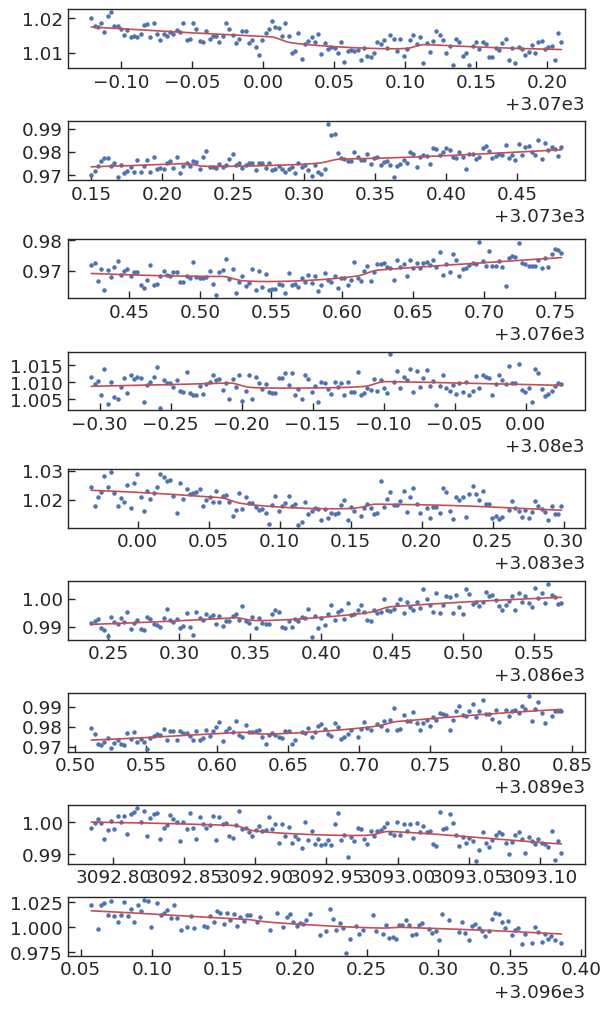

In [202]:
fig = plot_all_transits(alles, lc_name, toffset=2457000,
                        ncols=1, nrows=9, figsize=(6,10));